In [76]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Load the dataset
df = pd.read_csv(r"food_delivery\train.csv")  # Change to your actual filename

In [77]:
# Display the first few rows of the dataset
df.head()

# Summary info and data types
df.info()

# Basic statistics for numeric features
df.describe()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Order_Date                     0
Time_Orderd                    0
Time_Order_picked              0
Weatherconditions              0
Road_traffic_density           0
Vehicle_condition              0
Type_of_order                  0
Type_of_vehicle                0
multiple_deliveries            0
Festival                       0
City                           0
Time_taken(min)                0
dtype: int64

No missing data, but data types and strings still need to be cleaned up.

In [78]:
# Clean and prepare the data
df_clean = df.copy()

# Remove '(min) ' from Time_taken(min) and convert to int
df_clean['Time_taken(min)'] = df_clean['Time_taken(min)'].str.extract('(\d+)').astype(int)

# Convert ratings and age to numeric (coerce errors to NaN, then drop)
df_clean['Delivery_person_Ratings'] = pd.to_numeric(df_clean['Delivery_person_Ratings'], errors='coerce')
df_clean['Delivery_person_Age'] = pd.to_numeric(df_clean['Delivery_person_Age'], errors='coerce')

# Convert date/time fields
df_clean['Order_Date'] = pd.to_datetime(df_clean['Order_Date'], format='%d-%m-%Y', errors='coerce')
df_clean['Time_Orderd'] = pd.to_datetime(df_clean['Order_Date'].astype(str) + ' ' + df_clean['Time_Orderd'], errors='coerce')
df_clean['Time_Order_picked'] = pd.to_datetime(df_clean['Order_Date'].astype(str) + ' ' + df_clean['Time_Order_picked'], errors='coerce')

# Clean string fields
str_cols = df_clean.select_dtypes(include='object').columns
df_clean[str_cols] = df_clean[str_cols].apply(lambda x: x.str.strip())

# Drop rows with any NaN values (for simplicity)
df_clean.dropna(inplace=True)

# Final check
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43594 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID                           43594 non-null  object        
 1   Delivery_person_ID           43594 non-null  object        
 2   Delivery_person_Age          43594 non-null  float64       
 3   Delivery_person_Ratings      43594 non-null  float64       
 4   Restaurant_latitude          43594 non-null  float64       
 5   Restaurant_longitude         43594 non-null  float64       
 6   Delivery_location_latitude   43594 non-null  float64       
 7   Delivery_location_longitude  43594 non-null  float64       
 8   Order_Date                   43594 non-null  datetime64[ns]
 9   Time_Orderd                  43594 non-null  datetime64[ns]
 10  Time_Order_picked            43594 non-null  datetime64[ns]
 11  Weatherconditions            43594 non-nu

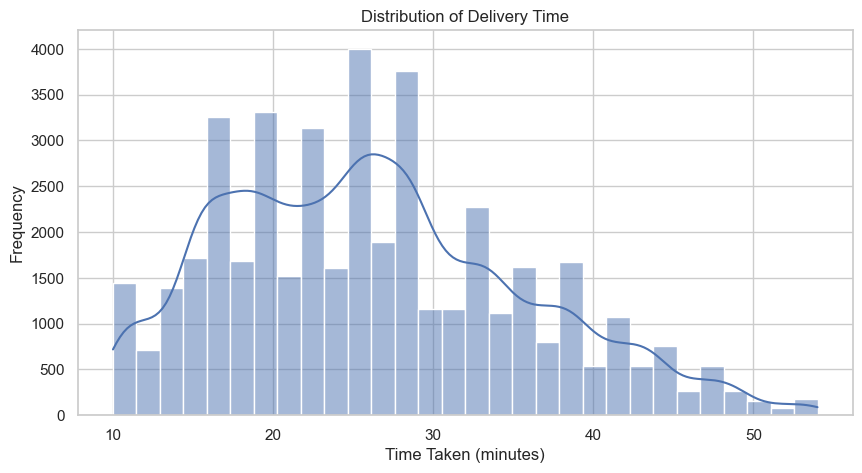

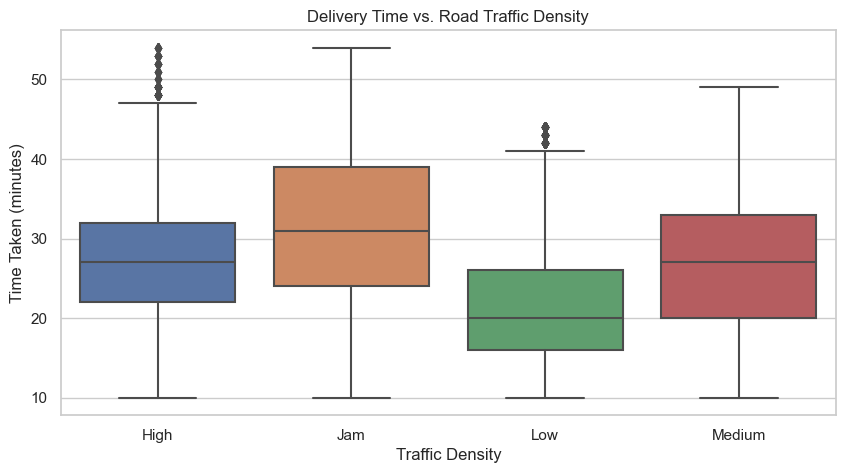

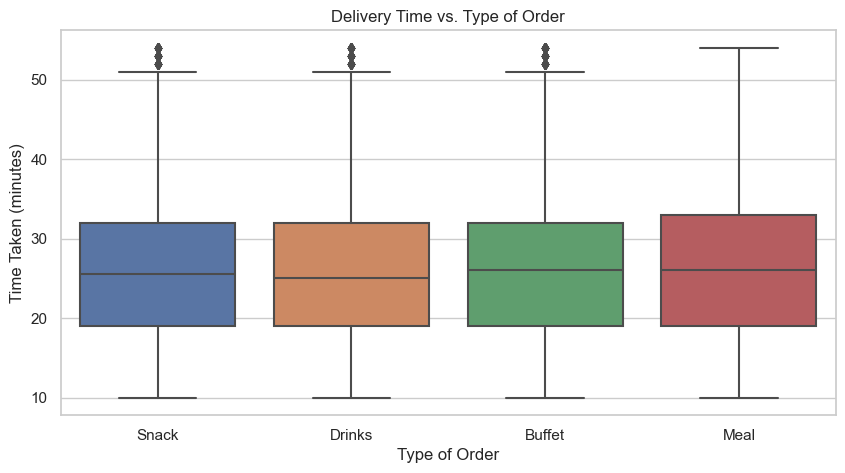

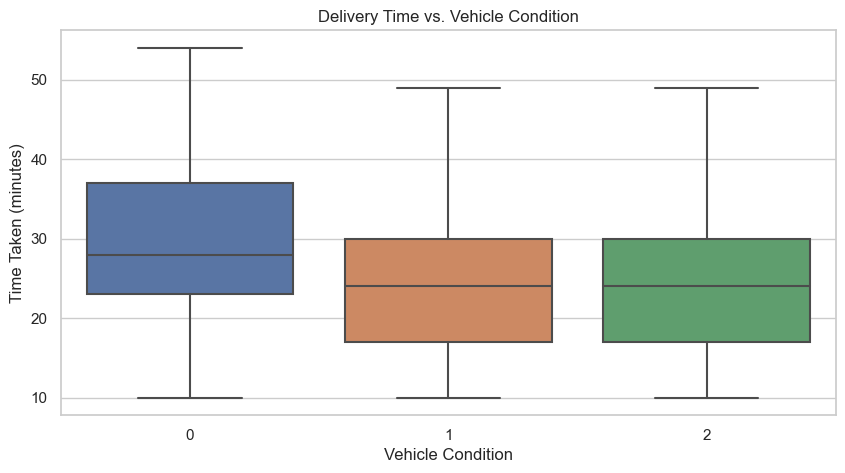

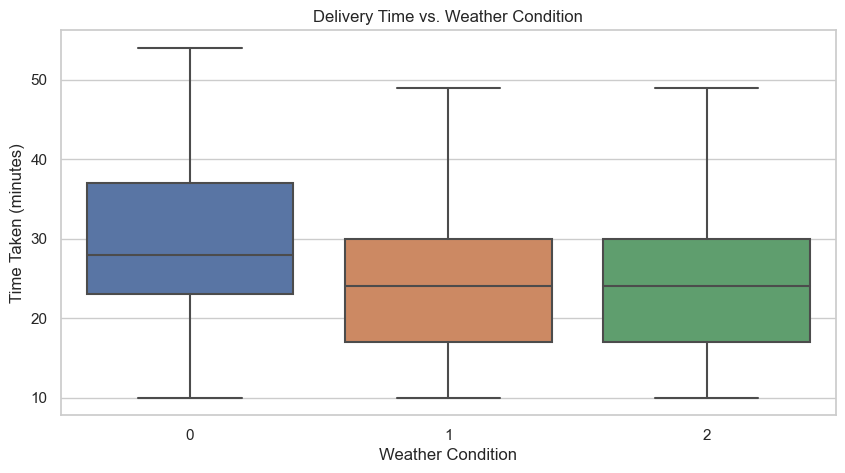

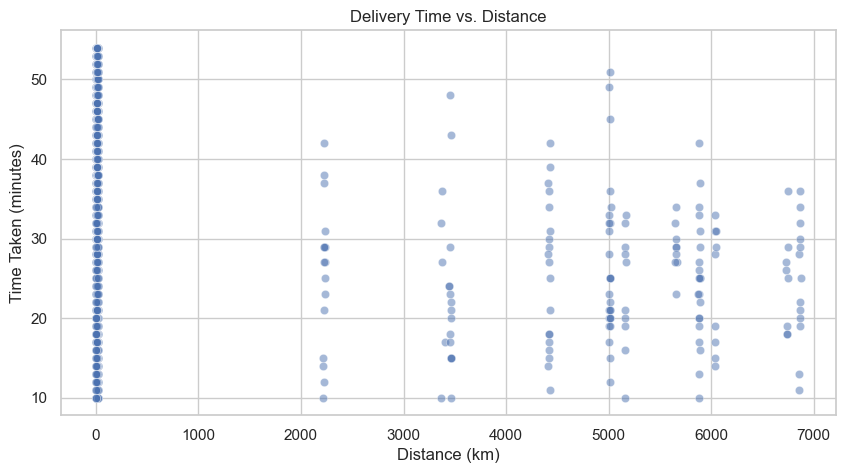

In [101]:
# Set plot theme
sns.set(style="whitegrid")

# Plot 1: Distribution of delivery time
plt.figure(figsize=(10, 5))
sns.histplot(df_clean['Time_taken(min)'], bins=30, kde=True)
plt.title("Distribution of Delivery Time")
plt.xlabel("Time Taken (minutes)")
plt.ylabel("Frequency")
plt.show()

# Plot 2: Boxplot of delivery time by traffic
plt.figure(figsize=(10, 5))
sns.boxplot(x='Road_traffic_density', y='Time_taken(min)', data=df_clean)
plt.title("Delivery Time vs. Road Traffic Density")
plt.xlabel("Traffic Density")
plt.ylabel("Time Taken (minutes)")
plt.show()

# Plot 3: Boxplot of delivery time by type of order
plt.figure(figsize=(10, 5))
sns.boxplot(x='Type_of_order', y='Time_taken(min)', data=df_clean)
plt.title("Delivery Time vs. Type of Order")
plt.xlabel("Type of Order")
plt.ylabel("Time Taken (minutes)")
plt.show()

# Plot 4: Boxplot of delivery time by vehicle condition
plt.figure(figsize=(10, 5))
sns.boxplot(x='Vehicle_condition', y='Time_taken(min)', data=df_clean)
plt.title("Delivery Time vs. Vehicle Condition")
plt.xlabel("Vehicle Condition")
plt.ylabel("Time Taken (minutes)")
plt.show()

# Plot 5: Boxplot of delivery time by weather condition
plt.figure(figsize=(10, 5))
sns.boxplot(x='Vehicle_condition', y='Time_taken(min)', data=df_clean)
plt.title("Delivery Time vs. Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Time Taken (minutes)")
plt.show()


# Plot 6: Scatter plot for distance vs time
df_clean['distance_km'] = ((df_clean['Restaurant_latitude'] - df_clean['Delivery_location_latitude'])**2 + 
                           (df_clean['Restaurant_longitude'] - df_clean['Delivery_location_longitude'])**2 )**0.5 * 111

plt.figure(figsize=(10, 5))
sns.scatterplot(x='distance_km', y='Time_taken(min)', data=df_clean, alpha=0.5)
plt.title("Delivery Time vs. Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Time Taken (minutes)")
plt.show()

MAE: 3.01
R^2 Score: 0.84


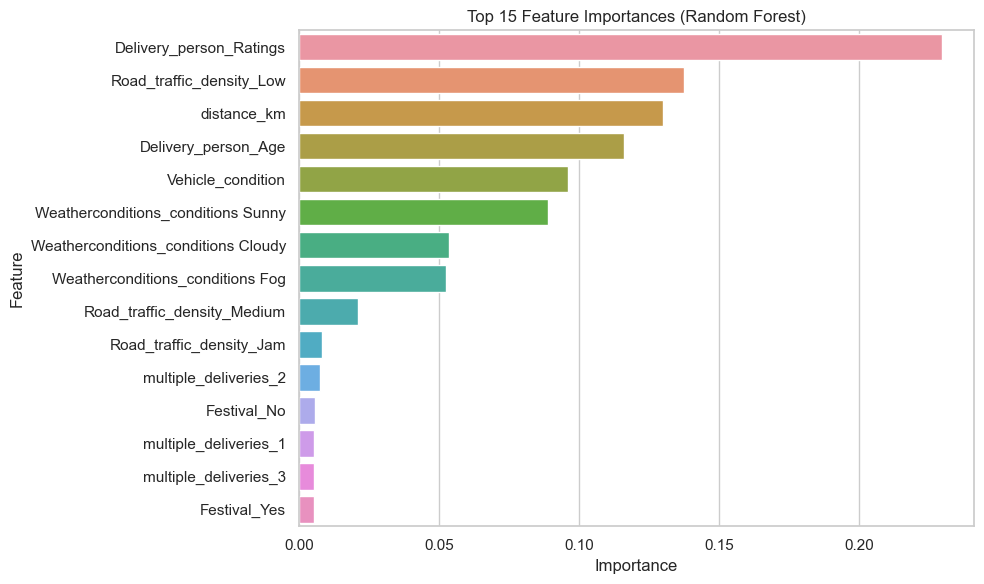

,Feature,Importance
30,Delivery_person_Ratings,0.229593
13,Road_traffic_density_Low,0.137546
32,distance_km,0.130021
29,Delivery_person_Age,0.116041
31,Vehicle_condition,0.096189
9,Weatherconditions_conditions Sunny,0.088838
5,Weatherconditions_conditions Cloudy,0.053553
6,Weatherconditions_conditions Fog,0.052391
14,Road_traffic_density_Medium,0.021155
12,Road_traffic_density_Jam,0.008274


In [100]:
# Prepare data for modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Features and target
features = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
            'multiple_deliveries', 'distance_km', 'Weatherconditions', 
            'Road_traffic_density', 'Type_of_order', 'Type_of_vehicle', 'City', 'Festival']
target = 'Time_taken(min)'

X = df_clean[features]
y = df_clean[target]

# Define preprocessing for categorical columns
categorical_features = ['multiple_deliveries', 'Weatherconditions', 'Road_traffic_density',
                        'Type_of_order', 'Type_of_vehicle', 'City', 'Festival']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Build pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth = 15, random_state=42))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2

print(f"MAE: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Extract feature names after one-hot encoding
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
encoded_cols = ohe.get_feature_names_out(categorical_features).tolist()

# Final feature names in the model
feature_names = encoded_cols + [
    f for f in features if f not in categorical_features
]

# Get feature importances from the trained RandomForest model
importances = model.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

feature_importance_df.head(15)

In [83]:
### Additional Feature Engineering

# Feature 1: Euclidean distance (already used, just keeping for reference)
df_clean['distance_km'] = ((df_clean['Restaurant_latitude'] - df_clean['Delivery_location_latitude'])**2 + 
                     (df_clean['Restaurant_longitude'] - df_clean['Delivery_location_longitude'])**2 )**0.5 * 111

# Feature 2: Absolute latitude difference (proxy for N-S distance)
df_clean['lat_diff'] = abs(df_clean['Restaurant_latitude'] - df_clean['Delivery_location_latitude'])

# Feature 3: Absolute longitude difference (proxy for E-W distance)
df_clean['lon_diff'] = abs(df_clean['Restaurant_longitude'] - df_clean['Delivery_location_longitude'])

# Feature 4: Order hour
df_clean['order_hour'] = df_clean['Time_Orderd'].dt.hour

# Feature 5: Order day of week
df_clean['order_dayofweek'] = df_clean['Order_Date'].dt.dayofweek  # Monday = 0

# Feature 6: Is peak lunch time (11am to 2pm)
df_clean['is_lunch_peak'] = df_clean['order_hour'].between(11, 14).astype(int)

# Feature 7: Is peak dinner time (6pm to 9pm)
df_clean['is_dinner_peak'] = df_clean['order_hour'].between(18, 21).astype(int)

# Feature 8: Weekend flag
df_clean['is_weekend'] = df_clean['order_dayofweek'].isin([5, 6]).astype(int)

# Feature 9: Is short range (<2km)
df_clean['is_short_range'] = (df_clean['distance_km'] < 2).astype(int)

# Feature 10: Latitude bucket (categorical proxy for zone)
df_clean['lat_bucket'] = pd.cut(df_clean['Restaurant_latitude'], bins=5, labels=False)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END regressor__learning_rate=0.05, regressor__max_depth=8, regressor__n_estimators=100;, score=0.843 total time=   1.7s
[CV 2/3] END regressor__learning_rate=0.05, regressor__max_depth=8, regressor__n_estimators=100;, score=0.845 total time=   1.7s
[CV 3/3] END regressor__learning_rate=0.05, regressor__max_depth=8, regressor__n_estimators=100;, score=0.845 total time=   1.7s
MAE: 2.84
R^2 Score: 0.86
Best Parameters: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 8, 'regressor__n_estimators': 100}


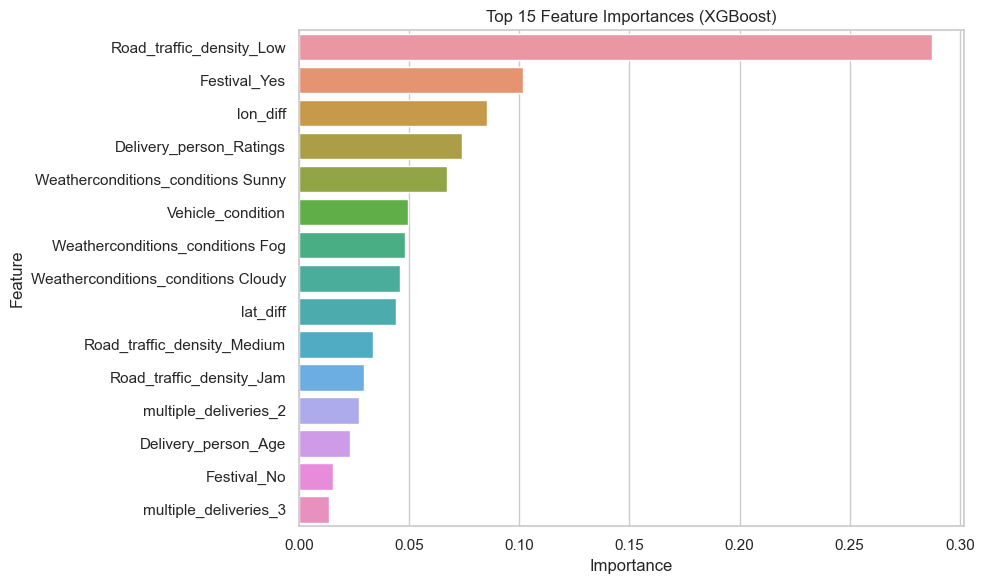

,Feature,Importance
13,Road_traffic_density_Low,0.287502
28,Festival_Yes,0.101546
39,lon_diff,0.085522
35,Delivery_person_Ratings,0.073829
9,Weatherconditions_conditions Sunny,0.067095
36,Vehicle_condition,0.049462
6,Weatherconditions_conditions Fog,0.048234
5,Weatherconditions_conditions Cloudy,0.045960
38,lat_diff,0.043933
14,Road_traffic_density_Medium,0.033429


In [94]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Feature Engineering ----------
df_clean['distance_km'] = ((df_clean['Restaurant_latitude'] - df_clean['Delivery_location_latitude'])**2 +
                           (df_clean['Restaurant_longitude'] - df_clean['Delivery_location_longitude'])**2)**0.5 * 111
df_clean['lat_diff'] = abs(df_clean['Restaurant_latitude'] - df_clean['Delivery_location_latitude'])
df_clean['lon_diff'] = abs(df_clean['Restaurant_longitude'] - df_clean['Delivery_location_longitude'])
df_clean['order_hour'] = df_clean['Time_Orderd'].dt.hour
df_clean['order_dayofweek'] = df_clean['Order_Date'].dt.dayofweek
df_clean['is_lunch_peak'] = df_clean['order_hour'].between(11, 14).astype(int)
df_clean['is_dinner_peak'] = df_clean['order_hour'].between(18, 21).astype(int)
df_clean['is_weekend'] = df_clean['order_dayofweek'].isin([5, 6]).astype(int)
df_clean['is_short_range'] = (df_clean['distance_km'] < 2).astype(int)
df_clean['lat_bucket'] = pd.cut(df_clean['Restaurant_latitude'], bins=5, labels=False)

# ---------- Feature Set ----------
features_extended = [
    'Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
    'multiple_deliveries', 'distance_km', 'lat_diff', 'lon_diff',
    'Weatherconditions', 'Road_traffic_density', 'Type_of_order', 'Type_of_vehicle',
    'City', 'Festival', 'order_hour', 'order_dayofweek', 'is_lunch_peak',
    'is_dinner_peak', 'is_weekend', 'is_short_range', 'lat_bucket'
]
target = 'Time_taken(min)'

X = df_clean[features_extended]
y = df_clean[target]

# ---------- Categorical Columns ----------
categorical_features_ext = [
    'multiple_deliveries', 'Weatherconditions', 'Road_traffic_density', 'Type_of_order',
    'Type_of_vehicle', 'City', 'Festival', 'lat_bucket'
]

# ---------- Preprocessing & Pipeline ----------
preprocessor_ext = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_ext)],
    remainder='passthrough'
)

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_ext),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# ---------- Hyperparameter Tuning ----------
param_grid = {
    'regressor__n_estimators': [100],
    'regressor__max_depth': [8],
    'regressor__learning_rate': [0.05]
}

grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=3, scoring='r2', verbose=3)
grid_search.fit(X, y)

# ---------- Evaluation ----------
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(f"Best Parameters: {grid_search.best_params_}")

# ---------- Feature Importances ----------
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']
encoded_cols = ohe.get_feature_names_out(categorical_features_ext).tolist()
feature_names = encoded_cols + [f for f in features_extended if f not in categorical_features_ext]

importances = best_model.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# ---------- Plot ----------
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

feature_importance_df.head(15)